# Filtering the RNA-Seq data with respect to metadata

In this notebook and Proteomics.ipynb, the available data is tested against their predictive power of metadata using the random forest classifier. Two rounds of classification with binary target variables is performed, with one having gender as the target,  and the other having the msi tumor characteristic as the target variable.

In [1]:
!ls
#######################################################################

Gender Visual.ipynb   Proteomics.ipynb      preprocess.py
Import.ipynb          RNA-Seq Final.ipynb   raw_data
MSI Visual.ipynb      RNA-Seq.ipynb
NA with RNA-Seq.ipynb __pycache__


In [2]:
import sys
import os
from IPython.utils import io
from io import StringIO

import re
import csv

import pandas as pd
import numpy as np
import scipy 
from scipy.cluster import hierarchy as hc # for dendograms 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# %matplotlib notebook

from sklearn.metrics import f1_score # f1_score(y_true, y_pred)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

## Import & show data 

The initial data proprocess was done in the Import.ipynb notebook. The following three steps are performed in all other jupyter notebooks: run the preprocess.py code that was generated in Import.ipynb, run the %whos magic command to see what dataframes have been imported, and then format the captured %who results with pandas to view results. #### show the imported dataframes

In [3]:
%run preprocess.py
# made in Import.ipynb

In [4]:
with io.capture_output() as captured:
    %whos DataFrame 

s = re.findall(r'\S+|\n', StringIO(captured.stdout).getvalue())

In [6]:
table = []
row = []

for item in s:
    if (item == '\n'):
        if (row):
            table.append(row)
        row = []
    elif re.match('^(?!-)', item) is None:
        pass        
    else: 
        row.append(item)

for item in table: 
    if (item[0] == 'Variable'):
        pass
    else:
        item[2:] = [' , '.join(item[2:])]

df = pd.DataFrame(data=table[1:], columns=table[0])
pd.set_option('display.max_colwidth', -1)
df

,Variable,Type,Data/Info
0,df_test_cli,DataFrame,"sample , gender , <...>g_80 , Female , MSI-High"
1,df_test_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
2,df_test_rna,DataFrame,"A1BG , A1B<...>[80 , rows , x , 17447 , columns]"
3,df_train_cli,DataFrame,"sample , gender , <...>g_80 , Female , MSI-Low/MSS"
4,df_train_mislabel,DataFrame,"sample , mismatch<...>79 , Training_80 , 1"
5,df_train_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
6,df_train_rna,DataFrame,"A1BG , A1<...>[80 , rows , x , 17447 , columns]"
7,test_cli,DataFrame,"gender , msi\n<...>\nTesting_80 , 1 , 1"
8,test_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
9,test_rna,DataFrame,"A1BG , A1B<...>[80 , rows , x , 17447 , columns]"


In [29]:
# train_pro_combined.head()

In [30]:
# train_rna_combined.head()

## Process

The steps followed for each target are: 

1. Split into train and test sets.
2. Run grid search to find best hyperparameters for random forest classifier. 
3. get rid of less predicitve genes in the dataset, using the variable importance threshhold. 
4. visualize the results and the relations between selected variables with a dendrogram. 

In [9]:
train_combined_correct =\
    train_rna_combined.loc[train_rna_combined['mismatch'] == 0]

X_correct = train_combined_correct.drop(['mismatch'], 
                                        axis=1, 
                                        inplace=False)

X_correct.reset_index(drop=True, inplace=True)

gender_correct = X_correct['gender']
msi_correct = X_correct['msi']
X_correct = X_correct.drop(['gender', 'msi'], axis=1, inplace=False)

columns = X_correct.columns

In [10]:
# X_correct
# gender_correct
# msi_correct

In [11]:
X_gender_train, X_gender_valid, y_gender_train, y_gender_valid =\
\
    train_test_split(X_correct.values.astype(int),
                     gender_correct, 
                     test_size=0.3)

In [12]:
# X_train
# X_valid
# y_train
# y_valid

In [13]:
# forest = RandomForestClassifier(n_estimators=500, 
#                                 n_jobs=-1, 
#                                 oob_score=True)

# # sorted(forest.get_params().keys())

# gs = GridSearchCV(estimator=forest,
#                   param_grid=[{'min_samples_leaf':[1, 3, 5, 10, 25, 100], 
#                                'max_features':[None, 0.5, 'sqrt', 'log2']}],
#                   scoring='accuracy',
#                   cv=5,)

# gs = gs.fit(X_gender_train, y_gender_train)
# print(gs.best_score_)
# print(gs.best_params_)

 1) DDX3Y                          0.492666
 2) UTY                            0.173533
 3) RPS4Y1                         0.168429
 4) EIF1AY                         0.025072
 5) TMSB4Y                         0.024864
 6) GYG2P1                         0.021672
 7) PRKY                           0.016430
 8) KDM6A                          0.005332
 9) ZFX                            0.004983
10) ZRSR2                          0.003193
11) BEX5                           0.002226
12) XIST                           0.001915
13) NMU                            0.001707
14) TMEM176B                       0.000884
15) DES                            0.000720
16) GPT                            0.000659
17) AKR7L                          0.000653
18) YPEL5                          0.000597
19) PIGW                           0.000584
20) TCEANC                         0.000560
21) GDAP2                          0.000543
22) EPHX2                          0.000526
23) C11orf74                    

<BarContainer object of 17447 artists>

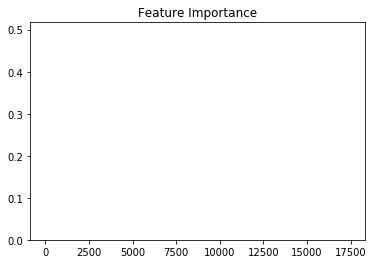

In [17]:
gender_forest = RandomForestClassifier(n_estimators=500,
                                min_samples_leaf=3,
                                max_features=None,
                                n_jobs=-1, 
                                oob_score=True)

gender_forest.fit(X_gender_train, y_gender_train)

gender_importances = gender_forest.feature_importances_
gender_indices = np.argsort(gender_importances)[::-1]

# for f in range(X_gender_train[1]): # to get the full results
for f in range(100):
    print("%2d) %-*s %f" % (f + 1, 
                            30, 
                            columns[gender_indices[f]], 
                            gender_importances[gender_indices[f]]))
    
plt.title('Feature Importance')

plt.bar(range(X_gender_train.shape[1]), 
        gender_importances[gender_indices], 
        align='center')

In [18]:
y_gender_pred = gender_forest.predict(X_gender_valid)

print('k=5 Nearest Neighbors: \n', 
      classification_report(y_true=y_gender_valid, y_pred=y_gender_pred))

print('OOB score: ', gender_forest.oob_score_)

k=5 Nearest Neighbors: 
              precision    recall  f1-score   support

          0       0.80      0.40      0.53        10
          1       0.62      0.91      0.74        11

avg / total       0.71      0.67      0.64        21

OOB score:  0.9148936170212766


In [19]:
gender_select = SelectFromModel(gender_forest, threshold=0.001)

gender_select.fit(X_gender_train, y_gender_train)

X_gender_important_train = gender_select.transform(X_gender_train)
X_gender_important_train_df = pd.DataFrame(X_gender_important_train)
X_gender_important_valid = gender_select.transform(X_gender_valid)

In [20]:
gender_forest.fit(X_gender_important_train, y_gender_train)
y_pred = gender_forest.predict(X_gender_important_valid)

print('k=5 Nearest Neighbors: \n', 
      classification_report(y_true=y_gender_valid, y_pred=y_gender_pred))

print('OOB score: ', gender_forest.oob_score_)

k=5 Nearest Neighbors: 
              precision    recall  f1-score   support

          0       0.80      0.40      0.53        10
          1       0.62      0.91      0.74        11

avg / total       0.71      0.67      0.64        21

OOB score:  0.9148936170212766


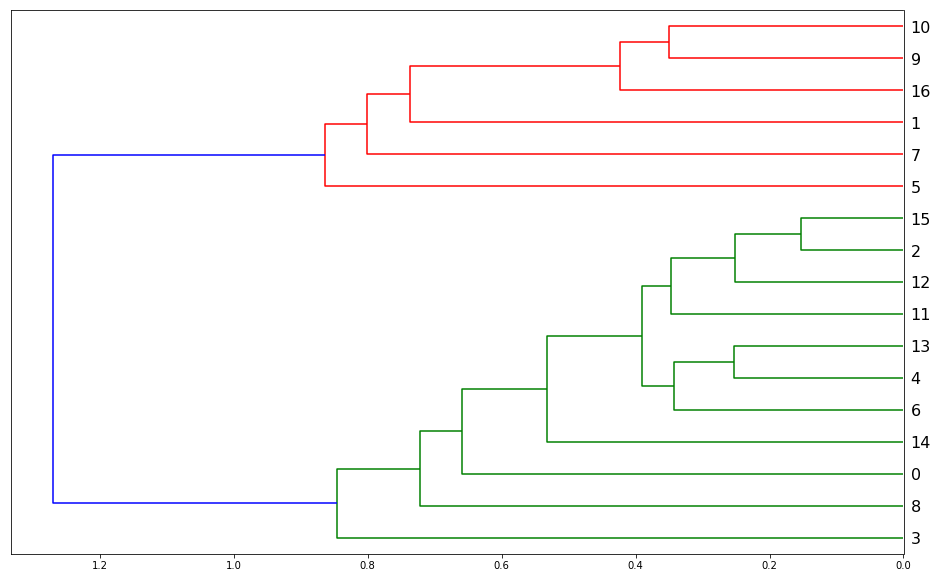

In [21]:
gender_corr = np.round(
                   scipy.stats.spearmanr(X_gender_important_train).correlation
                   , 4)

gender_corr_condensed = hc.distance.squareform(1-gender_corr)

z = hc.linkage(gender_corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
gender_dendrogram = hc.dendrogram(
    z, 
    labels=X_gender_important_train_df.columns, 
    orientation='left', 
    leaf_font_size=16)

plt.show()

In [22]:
X_msi_train, X_msi_valid, y_msi_train, y_msi_valid =\
\
    train_test_split(X_correct.values.astype(int),
                     msi_correct,
                     test_size=0.3)

In [23]:
# forest = RandomForestClassifier(n_estimators=500, 
#                                 n_jobs=-1, 
#                                 oob_score=True)

# # sorted(forest.get_params().keys())

# gs = GridSearchCV(estimator=forest,
#                   param_grid=[{'min_samples_leaf':[1, 3, 5, 10, 25, 100], 
#                                'max_features':[None, 0.5, 'sqrt', 'log2']}],
#                   scoring='accuracy',
#                   cv=5,)

# gs = gs.fit(X_msi_train, y_msi_train)
# print(gs.best_score_)
# print(gs.best_params_)

 1) POU5F1B                        0.370926
 2) CIITA                          0.057445
 3) IRF1                           0.057444
 4) RAB32                          0.049792
 5) GBP4                           0.027734
 6) MAX                            0.025904
 7) SMCHD1                         0.019892
 8) ODF3B                          0.019735
 9) CCL4                           0.013971
10) TGFBR2                         0.013837
11) PRSS23                         0.013830
12) DNAH14                         0.013829
13) APOL2                          0.011931
14) CAMK2N2                        0.011910
15) TNFAIP2                        0.011864
16) AFAP1-AS1                      0.011757
17) IRX2                           0.009951
18) BATF2                          0.009927
19) AREG                           0.009811
20) EPDR1                          0.008000
21) ZCCHC2                         0.008000
22) AXIN2                          0.008000
23) APOC1P1                     

<BarContainer object of 17447 artists>

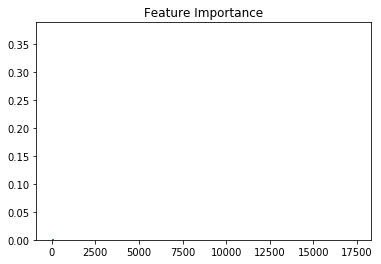

In [24]:
msi_forest = RandomForestClassifier(n_estimators=500,
                                min_samples_leaf=5,
                                max_features=None,
                                n_jobs=-1, 
                                oob_score=True)

msi_forest.fit(X_msi_train, y_msi_train)

msi_importances = msi_forest.feature_importances_
msi_indices = np.argsort(msi_importances)[::-1]

# for f in range(X_train.shape[1]): # to get the full results
for f in range(100):
    print("%2d) %-*s %f" % (f + 1, 
                            30, 
                            columns[msi_indices[f]], 
                            msi_importances[msi_indices[f]]))
    
plt.title('Feature Importance')

plt.bar(range(X_msi_train.shape[1]), 
        msi_importances[msi_indices], 
        align='center')

In [25]:
y_msi_pred = msi_forest.predict(X_msi_valid)

print('k=5 Nearest Neighbors: \n', 
      classification_report(y_true=y_msi_valid, y_pred=y_msi_pred))

print('OOB score: ', msi_forest.oob_score_)

k=5 Nearest Neighbors: 
              precision    recall  f1-score   support

          0       0.94      1.00      0.97        17
          1       1.00      0.75      0.86         4

avg / total       0.96      0.95      0.95        21

OOB score:  0.9148936170212766


In [26]:
msi_select = SelectFromModel(msi_forest, threshold=0.005)

msi_select.fit(X_msi_train, y_msi_train)

X_msi_important_train = msi_select.transform(X_msi_train)
X_msi_important_train_df = pd.DataFrame(X_msi_important_train)
X_msi_important_valid = msi_select.transform(X_msi_valid)

In [27]:
msi_forest.fit(X_msi_important_train, y_msi_train)
y_msi_pred = msi_forest.predict(X_msi_important_valid)

print('k=5 Nearest Neighbors: \n', 
      classification_report(y_true=y_msi_valid, y_pred=y_msi_pred))

print('OOB score: ', msi_forest.oob_score_)

k=5 Nearest Neighbors: 
              precision    recall  f1-score   support

          0       0.94      1.00      0.97        17
          1       1.00      0.75      0.86         4

avg / total       0.96      0.95      0.95        21

OOB score:  0.9361702127659575


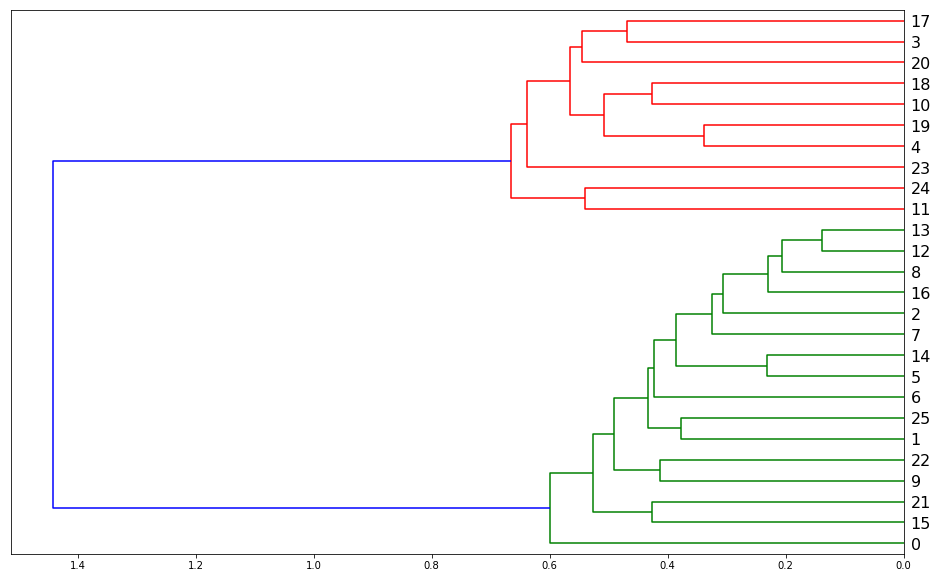

In [28]:
msi_corr = np.round(
                scipy.stats.spearmanr(X_msi_important_train).correlation
                , 4)

msi_corr_condensed = hc.distance.squareform(1-msi_corr)

msi_z = hc.linkage(msi_corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))

msi_dendrogram = hc.dendrogram(msi_z, 
                               labels=X_msi_important_train_df.columns, 
                               orientation='left', 
                               leaf_font_size=16)
plt.show()